# Preprocess raw EDF data to filtered FIF format

Define event names in a dictionary

In [1]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

from mne.preprocessing import ICA
from pyprep.find_noisy_channels import NoisyChannels

from IPython import display

import eeglabio

## define label dictionary for epoch annotations
## different keys account for different naming conventions
## NOTE: the Trigger#X naming convention does not specify between hand and back stimulus
custom_mapping = {'eyes closed': 1, 'Trigger#1': 1, 'EYES CLOSED': 1, # eyes closed
                  'eyes open': 2, 'eyes opened': 2, 'Trigger#2': 2, 'EYES OPEN': 2, # eyes open
                  'pinprick hand': 3, 'Yes Pain Hand': 3, 'Trigger#3': 3, 'HAND PINPRICK': 3, 
                  # highest intensity pain stimulus (first two HAND)
                  'Med Pain Hand': 4 , # intermediate intensity pain stimulus (HAND)
                  'No Pain Hand': 5, 'plastic hand': 5, 'Trigger#4': 5,  'HAND PLASTIC': 5,
                  # sensory stimulus, no pain (first two HAND)
                  'pinprick back': 6, 'Yes Pain Back': 6, 'BACK  PINPRICK': 6, 'Trigger#5': 6, 
                  # highest intensity pain stimulus (BACK)
                  'Med Pain Back': 7, # intermediate intensity pain stimulus (BACK)
                  'plastic back': 8, 'No Pain Back': 8, 'BACK PLASTIC': 8, 'Trigger#6': 8, 
                  # sensory stimulus, no pain (BACK)
                  'stop': 9, 'Stop': 9, 'STOP': 9, # stop
                  '1000001': 10,  '100160': 10, '100480': 10, # lesser weight pen tip down
                  '1000010': 11, # lesser weight pen tip up
                  '1100001': 12, '100320': 12, '100480': 12, # greater weight pen tip down
                  '1100010': 13, # greater weight pen tip up
                  }


Find EDF file based on subject number and load using MNE

In [2]:
sub_num = "018"

018.EEGDATA
018_preprocessed-raw.fif
018.EEGDATA
reading raw file...
Extracting EDF parameters from /home/wanglab/Documents/George Kenefati/EEG Decoding Project/EEG DATA/018.EEGDATA/Acquisition 018.Part2 Data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/wanglab/Documents/George Kenefati/EEG Decoding Project/EEG DATA/018.EEGDATA/Acquisition 018.Part2 Data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2959599  =      0.000 ...  2959.599 secs...
['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F11', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F12', 'FT11', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT12', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M1', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cb1', '

/tmp/ipykernel_12793/1498880792.py:77: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(custom_montage)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.7s finished


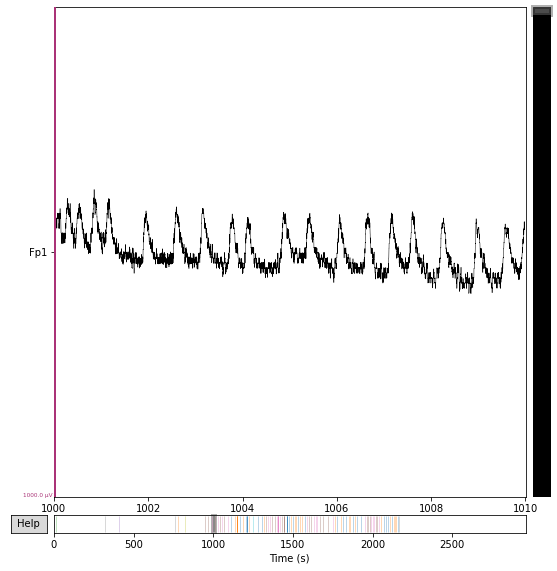

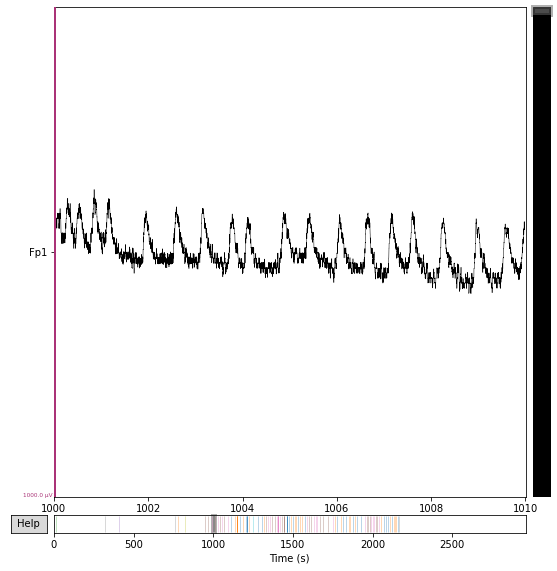

In [3]:
data_dir ="../../EEG DATA/"
save_dir ="../../Processed Data/"

sub_id=''; acq_id=''
for folder in os.listdir(data_dir):
    if (not folder.startswith('.') and folder.startswith(sub_num)):#and (folder[:3] in sub_fnames) and
    # (save_fname_fif not in os.listdir(save_dir))):
        sub_id = folder
        print(sub_id)
        save_fname_fif = sub_id[:3] + '_preprocessed-raw.fif'
        print(save_fname_fif)

for subfile in os.listdir(os.path.join(data_dir,sub_id)):
    if not subfile.endswith(".edf"):
        continue
    else:
        acq_id = subfile;

# read data, set EOG channel, and drop unused channels
print(f"{sub_id}\nreading raw file...")
eeg_data_raw_file = os.path.join(data_dir,sub_id,acq_id)

raw = mne.io.read_raw_edf(eeg_data_raw_file)

wrong_64_mtg_flag = 0
if "FT7" in raw.ch_names:
    wrong_64_mtg_flag = 1
    eog_adj = 4
else:
    eog_adj = 5

Fp1_eog_flag = 0
if "VEO" in raw.ch_names:
    del raw
    raw = mne.io.read_raw_edf(eeg_data_raw_file, eog=["VEO"], preload=True)
elif "VEOG" in raw.ch_names:
    del raw
    raw = mne.io.read_raw_edf(eeg_data_raw_file, eog=["VEOG"], preload=True)
elif "X" in raw.ch_names:
    Fp1_eog_flag = 1
    del raw
    raw = mne.io.read_raw_edf(eeg_data_raw_file, eog=["Fp1"], preload=True)

# display.clear_output(wait=True)

# high level inspection
print(raw.ch_names)
print(len(raw.ch_names))

# drop non EEG channels
if "HEOG" in raw.ch_names:
    non_eeg_chs = ['HEOG', 'EKG', 'EMG', 'Trigger']
    raw.drop_channels(non_eeg_chs)
elif "HEO" in raw.ch_names:
    non_eeg_chs = ['HEO', 'EKG', 'EMG', 'Trigger']
    raw.drop_channels(non_eeg_chs)
elif "X" in raw.ch_names:
    non_eeg_chs = ['X', 'Y', 'Z', 'Oth4']
    raw.drop_channels(non_eeg_chs)
elif "EEG66" in raw.ch_names:
    non_eeg_chs = ['EEG66','EEG67','EEG68','EEG69']
    raw.drop_channels(non_eeg_chs)
    
# make adjustment for wrong montage subjects
if wrong_64_mtg_flag:
    raw.drop_channels(['FT7','FT8','PO5','PO6']) # for C24, 055, 056, 047

print(raw.ch_names)
print(len(raw.ch_names))

# load electrode locations 
print(f"{sub_id}\nsetting custom montage...")
if wrong_64_mtg_flag:
    custom_montage = mne.channels.read_custom_montage('../Misc/Montage/Hydro_Neo_Net_64_xyz_cms_No_FID_Caps.sfp') 
else:
    custom_montage = mne.channels.read_custom_montage('../Misc/Montage/Hydro_Neo_Net_64_xyz_cms_No_FID.sfp') 
raw.set_montage(custom_montage)
# display.clear_output(wait=True)


# apply notch filter
print(f"{sub_id}\napplying notch filter...")
raw = raw.notch_filter(60., notch_widths=10)
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=1,scalings=0.0005)

018.EEGDATA
applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.1s finished


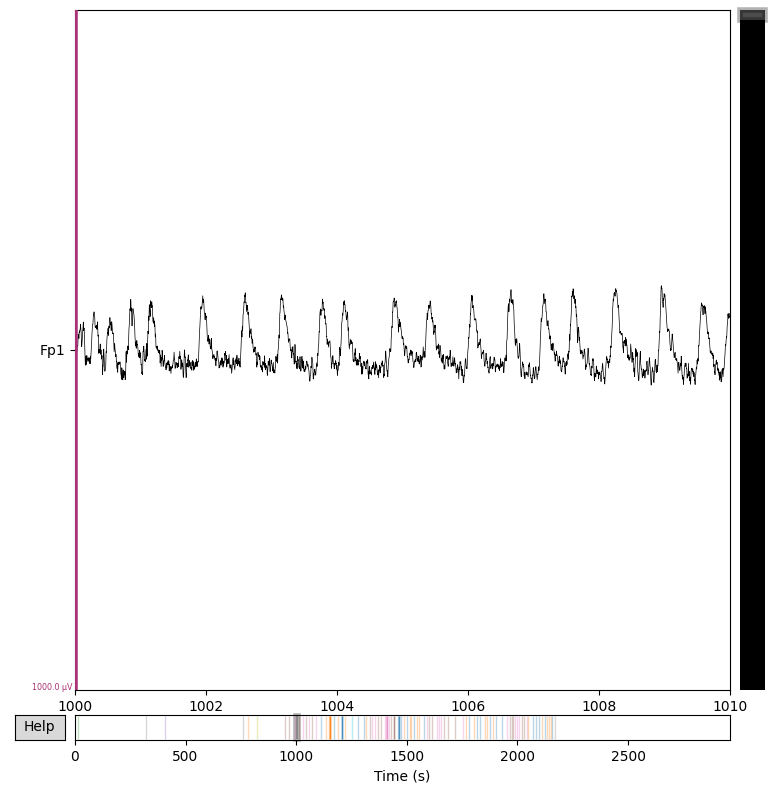

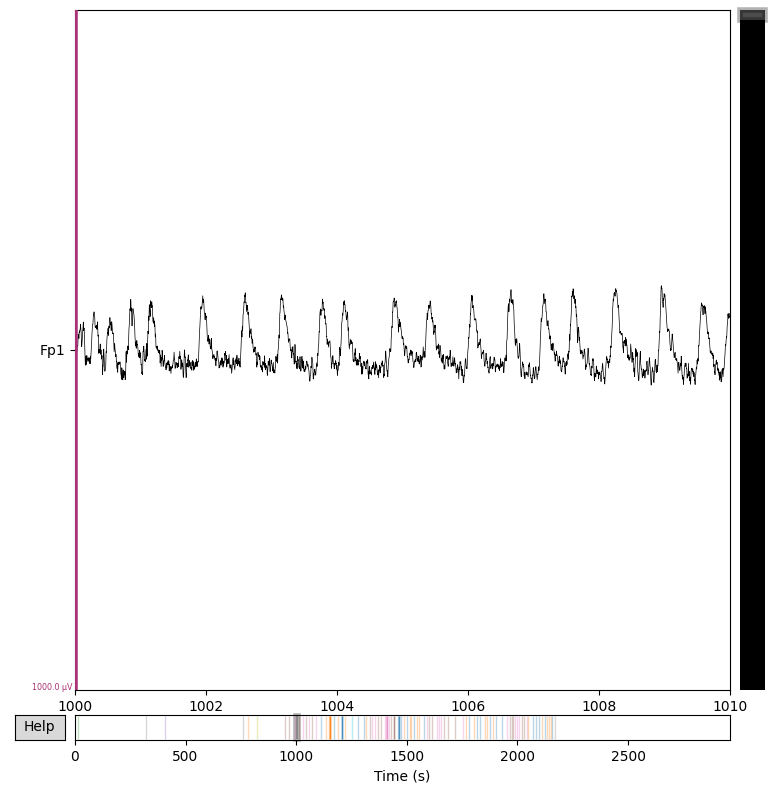

In [4]:

# apply bandpass filter
print(f"{sub_id}\napplying bandpass filter...")
raw = raw.filter(l_freq=1., h_freq=100.)
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=1,scalings=0.0005)


018.EEGDATA
resampling data from 1000.0 Hz to 400 Hz...


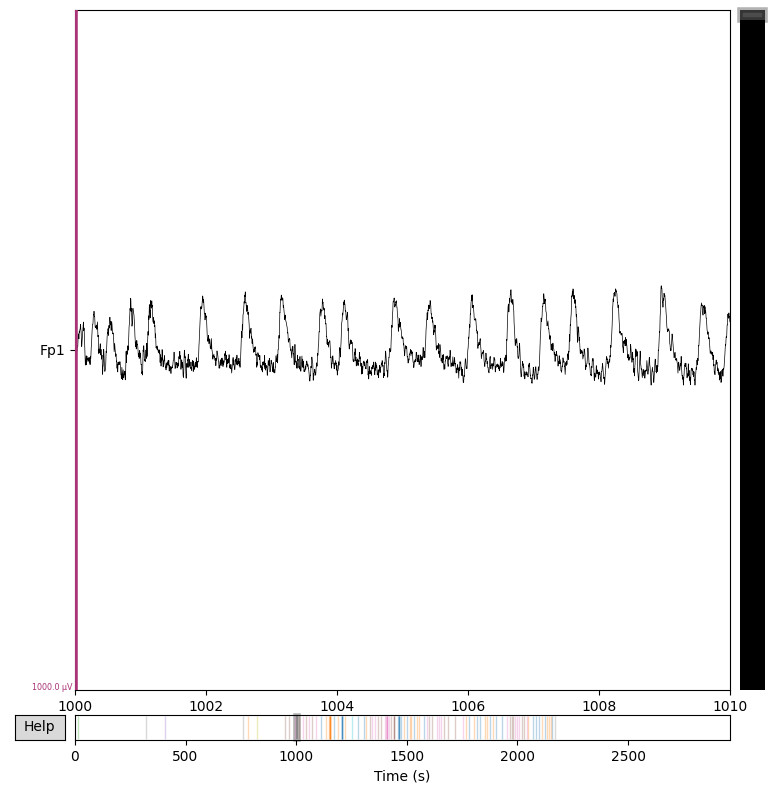

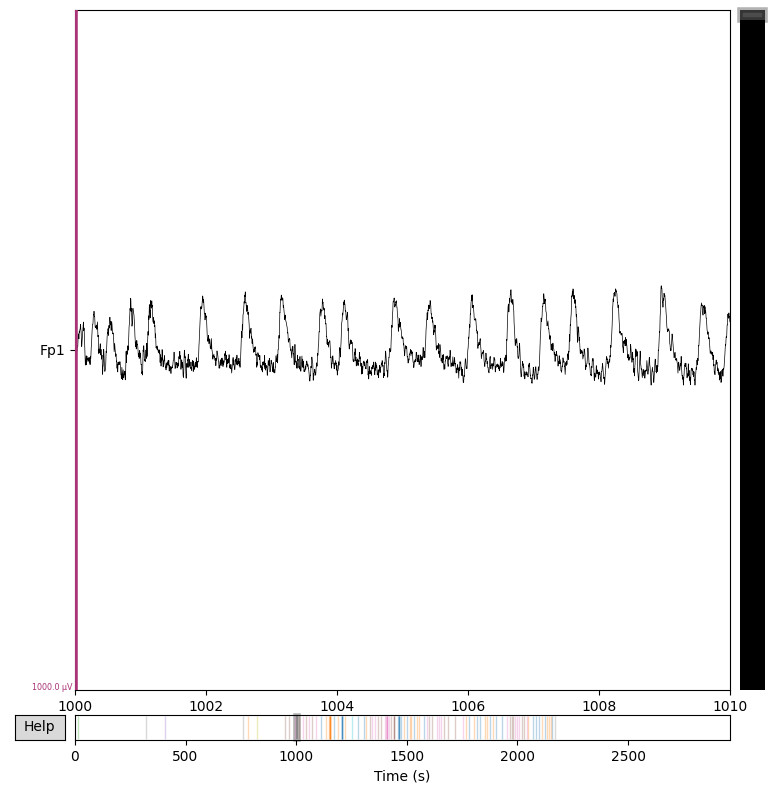

In [5]:

# resample data to decrease file size
resample_freq = 400
print(f"{sub_id}\nresampling data from {raw.info['sfreq']} Hz to {resample_freq} Hz...")
raw.resample(resample_freq, npad='auto')
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=1,scalings=0.0005)


018.EEGDATA
removing bad channels...
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1321 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.2s finished


Interpolating bad channels
    Automatic origin fit: head of radius 76.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors


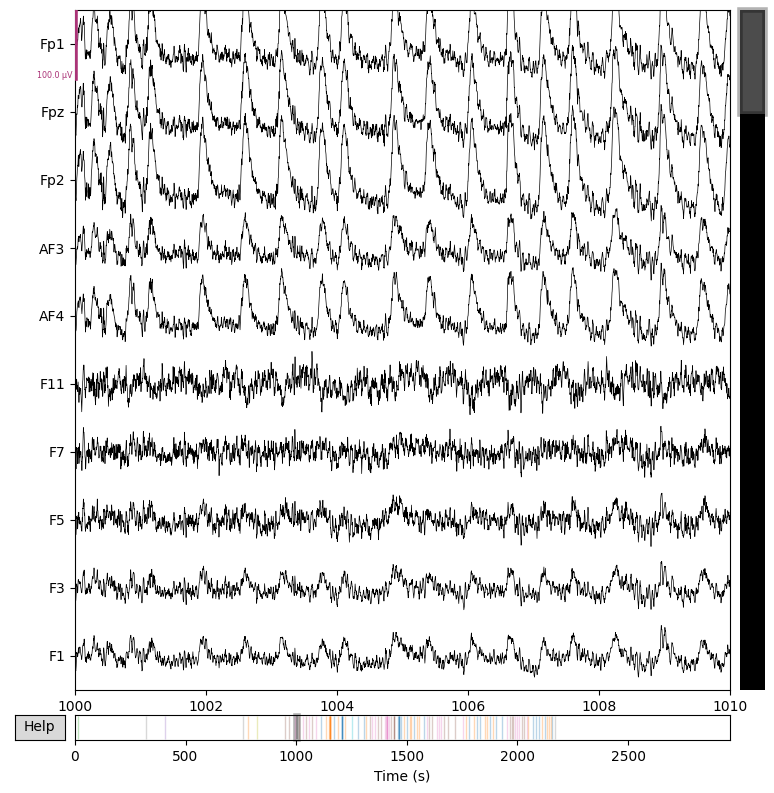

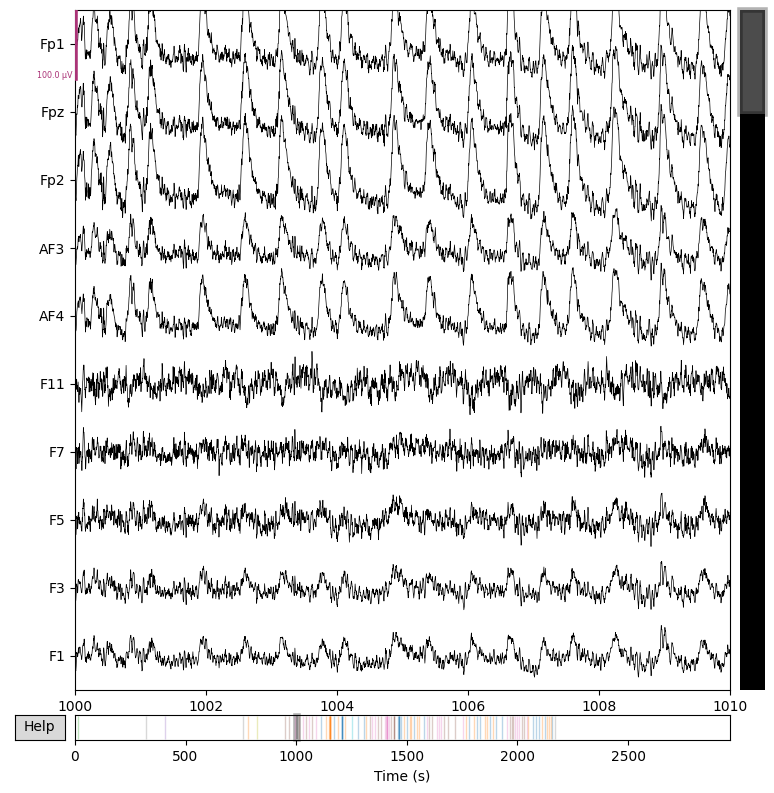

In [6]:
# find bad channels automatically
print(f"{sub_id}\nremoving bad channels...")
raw_pyprep = NoisyChannels(raw, random_state=42)
raw_pyprep.find_all_bads(ransac=False, channel_wise=False, max_chunk_size=None)
raw.info['bads'] = raw_pyprep.get_bads()
raw.interpolate_bads(reset_bads=True)
# display.clear_output(wait=True)
raw.plot(start=1000,n_channels=10,scalings=0.00005)

018.EEGDATA
re-referencing channels to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


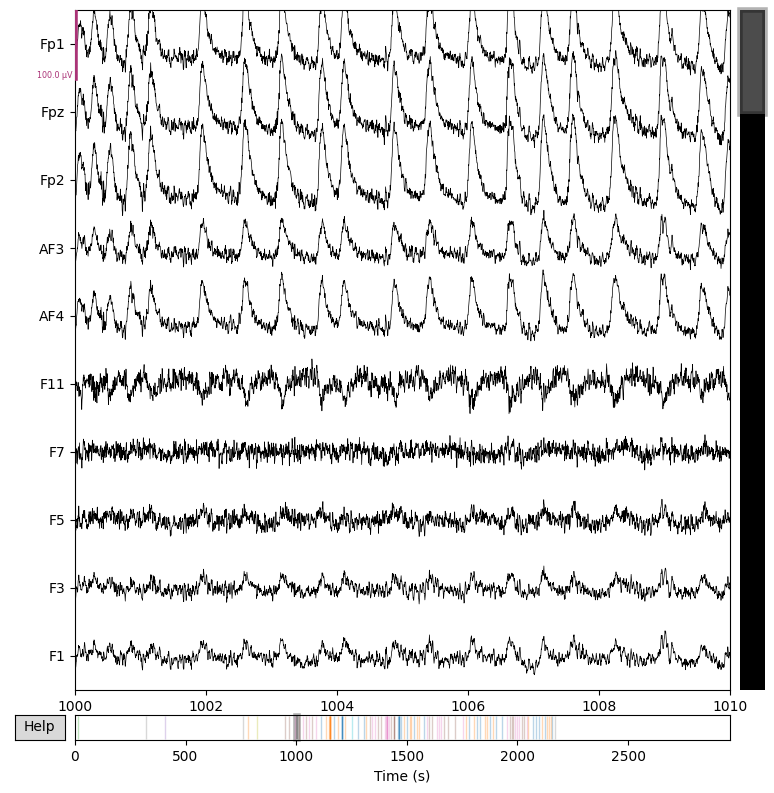

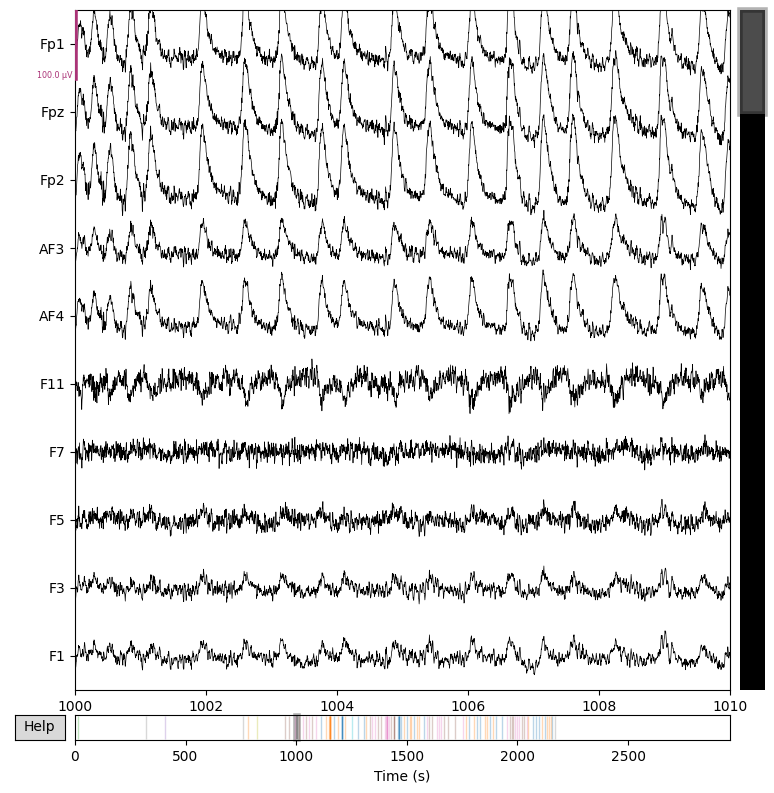

In [7]:
# re-reference channels
print(f"{sub_id}\nre-referencing channels to average...")
raw, _ = mne.set_eeg_reference(raw, ref_channels='average', copy=True)
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=10,scalings=0.00005)


018.EEGDATA
fitting ICA...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 83.7s.


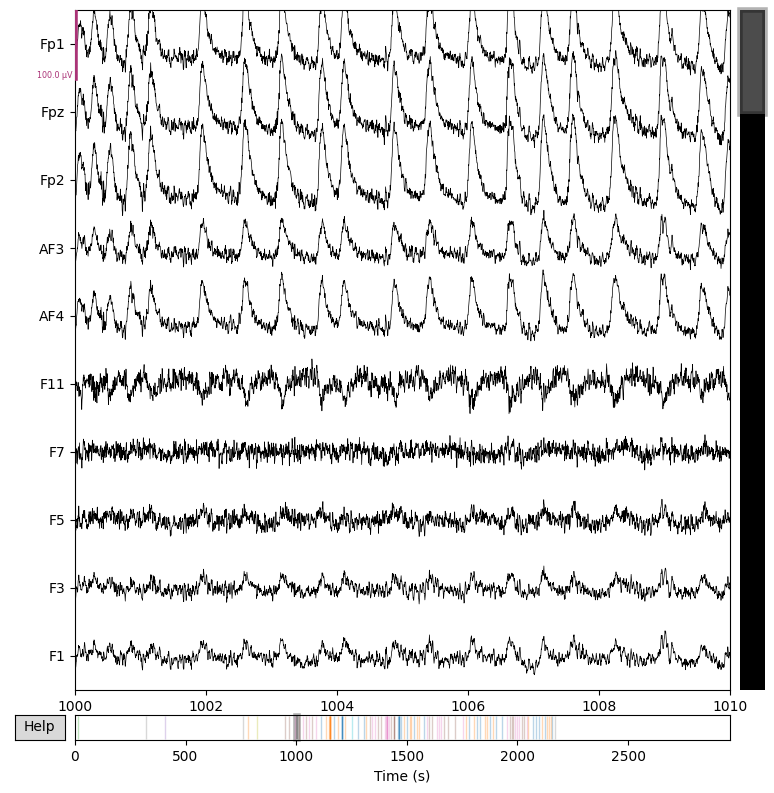

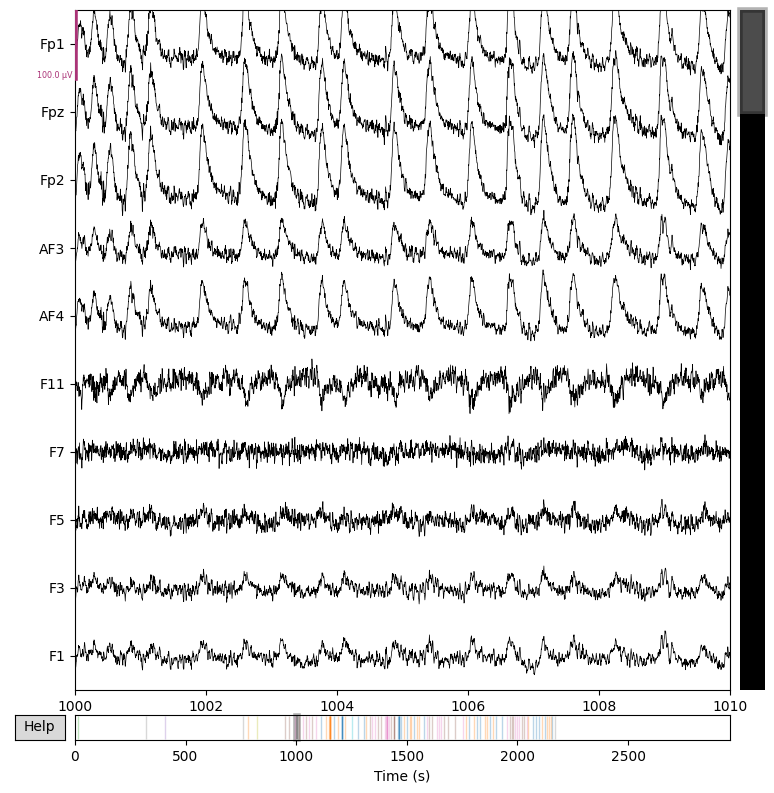

In [10]:
# fit ICA 
print(f"{sub_id}\nfitting ICA...")
num_goods = len(raw.ch_names) - len(raw.info['bads']) - 1 # adjust for EOG
ica = ICA(n_components=int(np.floor(num_goods/2)), random_state=42, max_iter='auto')
ica.fit(raw)
# display.clear_output(wait=True)
raw.plot(start=1000,n_channels=10,scalings=0.00005)

Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 4000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 4000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


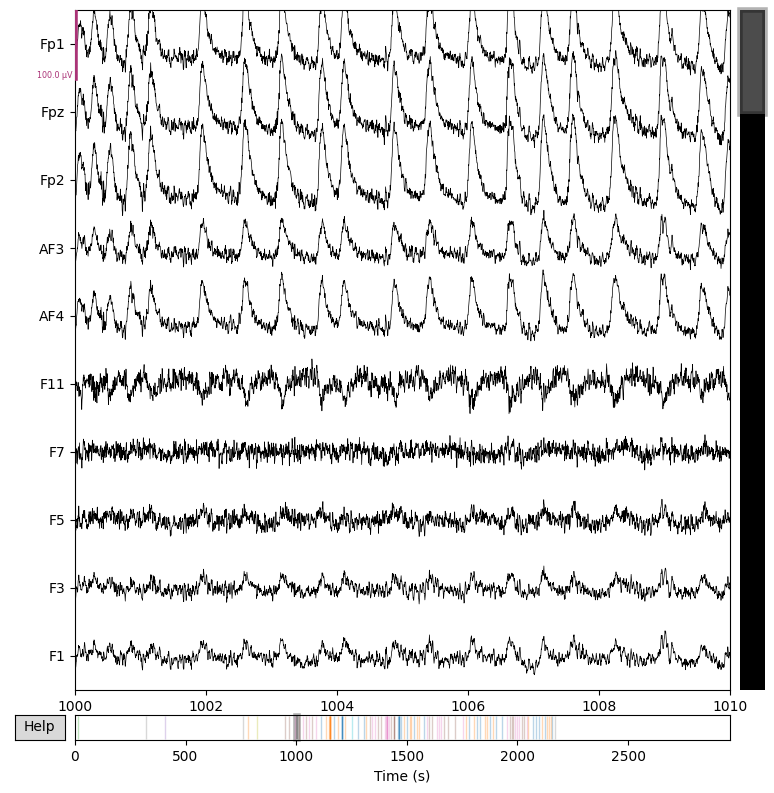

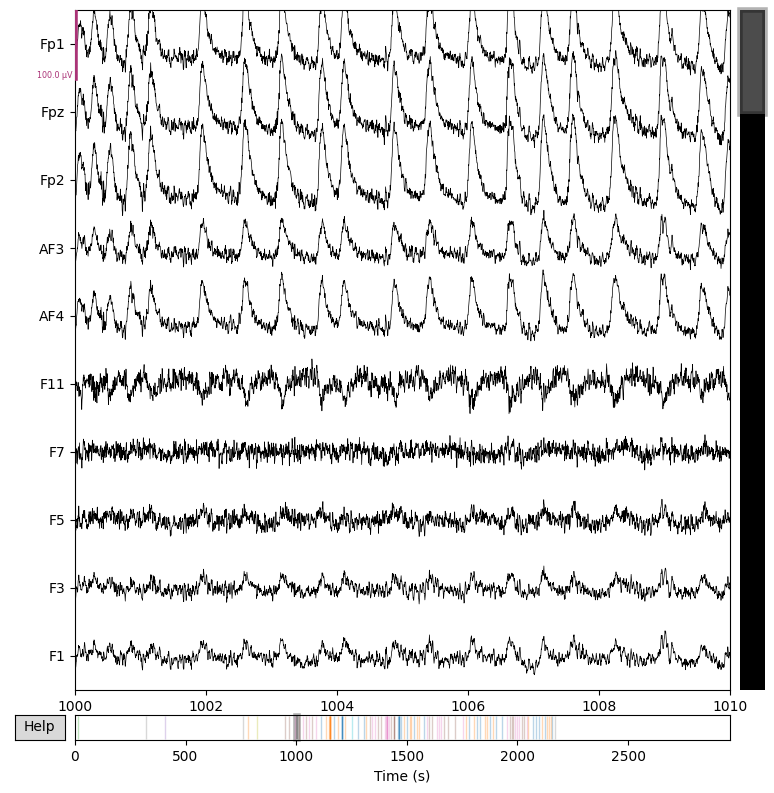

In [11]:

# find EOG artifacts
# print(f"{sub_id}\nfinding EOG artifacts...")
eog_indices, eog_scores = ica.find_bads_eog(raw,
                                            threshold='auto')
ica.exclude = eog_indices
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=10,scalings=0.00005)

In [12]:
eog_indices

[]

In [13]:
len(eog_indices)

0

018.EEGDATA
applying ICA...
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


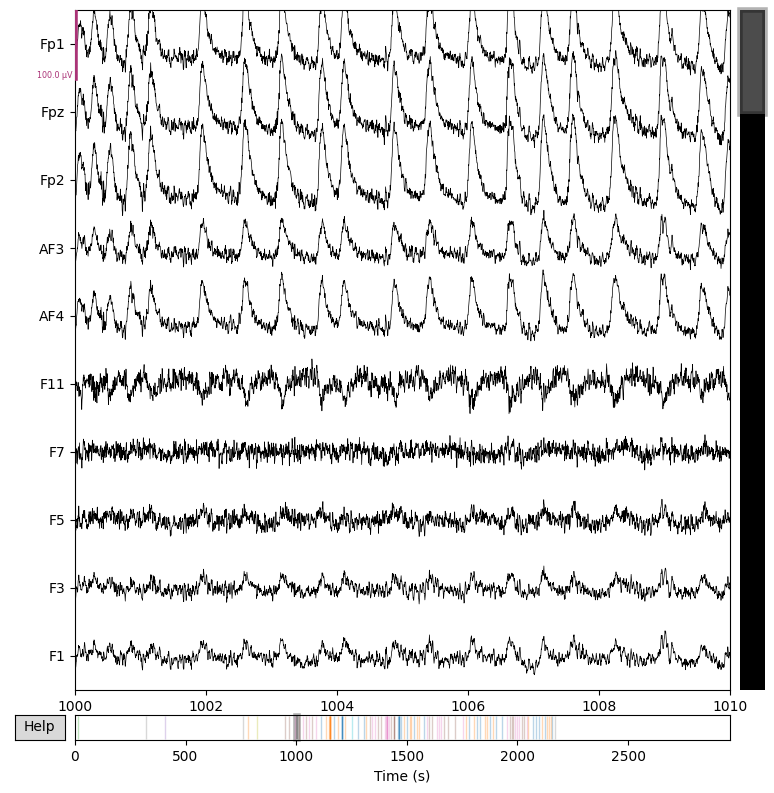

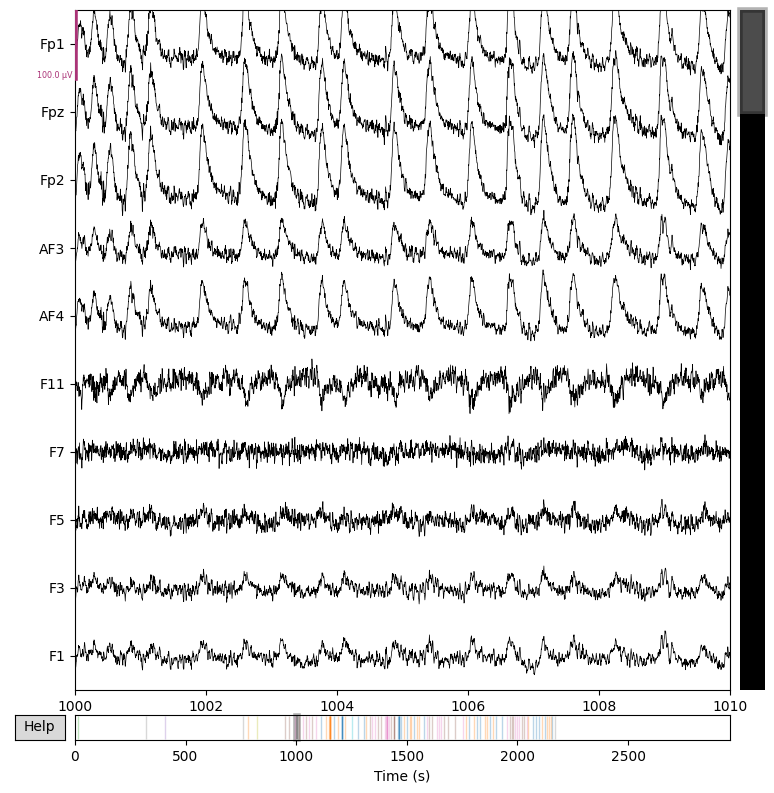

In [14]:
# apply ICA
print(f"{sub_id}\napplying ICA...")
ica.apply(raw)
# display.clear_output(wait=True)

raw.plot(start=1000,n_channels=10,scalings=0.00005)


In [15]:
# save copy of data
print(f"Saving processed data as '{save_fname_fif}'...")

if "VEO" in raw.ch_names:
    raw.drop_channels("VEO")
elif "VEOG" in raw.ch_names:
    raw.drop_channels("VEOG")
elif Fp1_eog_flag:
    raw.set_channel_types({'Fp1': 'eeg'})

set_dir = '../../SET Data/'
raw.save(save_dir+save_fname_fif, 
         verbose=True, overwrite=True)
mne.export.export_raw(set_dir+save_fname_fif[:-4]+'.set', 
                      raw, overwrite=True, verbose=True)
# display.clear_output(wait=True)

# high level inspection
# print(raw.ch_names)
print('\nNumber of remaining channels: ',len(raw.ch_names) - len(raw.info['bads']))
print('\nDropped channels: ',raw.info['bads'])

print("Raw data preprocessing complete.")

display.clear_output(wait=True)

Saving processed data as '018_preprocessed-raw.fif'...
Overwriting existing file.
Writing /home/wanglab/Documents/George Kenefati/EEG Decoding Project/Python Code/Preprocessing/../../Processed Data/018_preprocessed-raw.fif
Closing /home/wanglab/Documents/George Kenefati/EEG Decoding Project/Python Code/Preprocessing/../../Processed Data/018_preprocessed-raw.fif
[done]
Overwriting existing file.

Number of remaining channels:  64

Dropped channels:  []
Raw data preprocessing complete.
